# Profit Optimization via Reinforcement Learning

This notebook formalizes a discrete-time decision process for marketing investment. The agent selects a marketing action \(a_t\) at each period based on the state vector

	\( s_t = (	ext{demand}_t, 	ext{brand}_t, 	ext{cash}_t ) \).

The goal is to approximate the value function \(V(s)\) using TD(0) and to evaluate the behavior of a simple policy.


## Setup

Core scientific stack and display configuration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple

plt.style.use('seaborn-v0_8')


## Environment

The system evolves as a Markov decision process. Demand and brand follow controlled stochastic transitions. Cash evolves through deterministic revenue and stochastic cost. The reward is defined as revenue minus marketing cost.

State transitions follow

	\( s_{t+1} \sim P(s_{t+1} | s_t, a_t) \).

We parameterize revenue as

	\( r(s_t, a_t) = lpha \cdot 	ext{demand}_t + eta \cdot 	ext{brand}_t - c(a_t) \)


In [2]:
@dataclass(frozen=True)
class CompanyState:
    demand: int
    brand: int
    cash: int


class CompanyEnv:
    def __init__(self, gamma=0.9, seed=42, horizon=20):
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)
        self.horizon = horizon
        self.state = CompanyState(1, 1, 2)

    def reset(self):
        self.state = CompanyState(1, 1, 2)
        return self.state

    def step(self, action: int) -> Tuple[CompanyState, float]:
        d, b, c = self.state.demand, self.state.brand, self.state.cash
        demand_next = max(0, min(3, d + self.rng.integers(-1, 2) + action - 1))
        brand_next = max(0, min(3, b + (1 if action == 2 else 0)))
        cost = [0, 1, 2][action]
        revenue = d * 2 + b
        cash_next = max(0, min(3, c + revenue - cost))
        reward = revenue - cost
        self.state = CompanyState(demand_next, brand_next, cash_next)
        return self.state, reward


## Policy

A simple heuristic selects actions based on available cash and marginal demand conditions.

In [4]:
def marketing_policy(state: CompanyState) -> int:
    if state.cash == 0:
        return 0
    if state.demand <= 1:
        return 1
    return 2


## Temporal Difference Learning

We approximate the value function using TD(0). For each visited transition

	\( V(s_t) \leftarrow V(s_t) + \alpha [r_t + \gamma V(s_{t+1}) - V(s_t)] \).

Sampling trajectories under the policy yields a Monte Carlo rollout used to drive temporal-difference updates.

In [5]:
def td0(env: CompanyEnv, alpha=0.2, episodes=5000) -> Dict[CompanyState, float]:
    V: Dict[CompanyState, float] = {}
    for _ in range(episodes):
        s = env.reset()
        for _ in range(env.horizon):
            a = marketing_policy(s)
            s_next, r = env.step(a)
            V.setdefault(s, 0.0)
            V.setdefault(s_next, 0.0)
            V[s] += alpha * (r + env.gamma * V[s_next] - V[s])
            s = s_next
    return V

env = CompanyEnv(seed=21, horizon=20)
value_function = td0(env)


## Value Structure

Sort states by estimated value to inspect where the policy invests effectively.

In [6]:
sorted_V = sorted(value_function.items(), key=lambda x: -x[1])
for s, v in sorted_V[:10]:
    print(s, f"V={v:.2f}")


CompanyState(demand=3, brand=3, cash=3) V=70.00
CompanyState(demand=3, brand=2, cash=3) V=69.00
CompanyState(demand=np.int64(2), brand=3, cash=3) V=66.72
CompanyState(demand=np.int64(2), brand=2, cash=3) V=65.65
CompanyState(demand=np.int64(2), brand=1, cash=3) V=64.07
CompanyState(demand=np.int64(1), brand=1, cash=3) V=47.83
CompanyState(demand=1, brand=1, cash=2) V=42.91
CompanyState(demand=0, brand=1, cash=3) V=36.81


## Heatmap by Cash

Fixing cash produces a bivariate surface across demand and brand. This highlights the sensitivity of value to the two main growth levers.

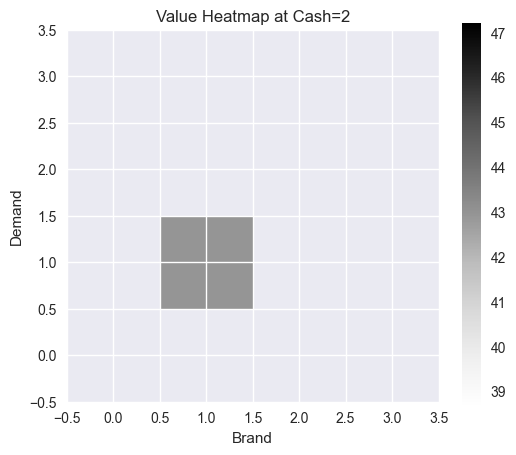

In [7]:
def plot_value_heatmap(V: Dict[CompanyState, float], cash: int):
    grid = np.zeros((4, 4))
    for d in range(4):
        for b in range(4):
            grid[d, b] = V.get(CompanyState(d, b, cash), np.nan)
    plt.figure(figsize=(6, 5))
    plt.imshow(grid, origin='lower')
    plt.colorbar()
    plt.xlabel('Brand')
    plt.ylabel('Demand')
    plt.title(f'Value Heatmap at Cash={cash}')
    plt.show()

plot_value_heatmap(value_function, cash=2)


## Sample Trajectory

A rollout under the heuristic policy shows how the controlled dynamics evolve.

In [8]:
env_t = CompanyEnv(seed=7, horizon=30)
trajectory = []
s = env_t.reset()
total_reward = 0
for _ in range(env_t.horizon):
    a = marketing_policy(s)
    s_next, r = env_t.step(a)
    trajectory.append((s, a, r, s_next))
    total_reward += r
    s = s_next

for t in trajectory:
    print(t)

total_reward


(CompanyState(demand=1, brand=1, cash=2), 1, 2, CompanyState(demand=np.int64(2), brand=1, cash=3))
(CompanyState(demand=np.int64(2), brand=1, cash=3), 2, np.int64(3), CompanyState(demand=3, brand=2, cash=3))
(CompanyState(demand=3, brand=2, cash=3), 2, 6, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, 

np.int64(200)

# SARSA

In [ ]:
class CompanyEnv:
    def __init__(self, gamma=0.9, seed=42):
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)
        self.max_level = 4
        self.reset()

    def reset(self):
        self.demand = 1
        self.brand = 1
        self.cash = 2
        return (self.demand, self.brand, self.cash)

    def step(self, action):

        revenue = 10 * self.demand + 15 * self.brand
        cost_table = [0, 5, 15, 30, 50]
        cost = cost_table[action]
        reward = revenue - cost

        demand_next = self._transition_demand(self.demand, self.brand, action)
        brand_next  = self._transition_brand(self.brand, action)
        cash_next   = self._transition_cash(self.cash, self.demand, self.brand, action)

        # update internal state
        self.demand = demand_next
        self.brand  = brand_next
        self.cash   = cash_next

        return (demand_next, brand_next, cash_next), reward, False, {}

    def _transition_demand(self, demand, brand, action):
        delta_d = 0.25 * action + 0.15 * brand - 0.5
        noise = self.rng.normal(0, 0.3)
        d_next = demand + delta_d + noise
        return int(round(np.clip(d_next, 0, 4)))

    def _transition_brand(self, brand, action):
        delta_b = 0.15 * action - 0.2
        noise = self.rng.normal(0, 0.2)
        b_next = brand + delta_b + noise
        return int(round(np.clip(b_next, 0, 4)))

    def _transition_cash(self, cash, demand, brand, action):
        revenue = 10 * demand + 15 * brand
        cost_table = [0,5,15,30,50]
        cost = cost_table[action]

        delta_c = (revenue - cost - 20) / 40   
        noise = self.rng.normal(0, 0.2)

        c_next = cash + delta_c + noise
        return int(round(np.clip(c_next, 0, 4)))



In [ ]:
def epsilon_greedy(Q, state, epsilon):

    if state not in Q:
        Q[state] = np.zeros(5)

    rand = np.random.random()

    if rand < epsilon:
        return np.random.choice(5)
    else:
        return np.argmax(Q[state])


In [30]:
def sarsa(env, alpha, gamma, epsilon, num_steps):
    
    Q = {}

    state = env.reset()
    action = epsilon_greedy(Q, state, epsilon)

    if state not in Q:
        Q[state] = np.zeros(5)

    for t in range(num_steps):
        next_state, reward, done, _ = env.step(action)

        next_action = epsilon_greedy(Q, next_state, epsilon)

        if next_state not in Q:
            Q[next_state] = np.zeros(5)
        
        if state not in Q:
            Q[state] = np.zeros(5)

        Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

        state = next_state 
        action = next_action

    return Q

In [33]:
env = CompanyEnv()
Q = sarsa(env, alpha=0.1, gamma=0.95, epsilon=0.1, num_steps=100000)
print(len(Q))
list(Q.items())[:10]


106


[((1, 1, 2),
  array([197.6503311 , 158.85195906, 145.55585174,  96.33187438,
         126.17696567])),
 ((1, 0, 2),
  array([69.02532825,  8.93741519,  7.4121367 ,  4.8252378 ,  4.94892698])),
 ((0, 0, 2),
  array([ 8.20569479, 16.28065759,  1.41229275, -0.43693357, 78.84180266])),
 ((0, 0, 1),
  array([-1.11781604, 58.72381611, -2.12960285, -2.98430942, -3.32493701])),
 ((0, 0, 0),
  array([ -7.34879316,  23.00418138, -12.86871266, -20.11545609,
         105.9831842 ])),
 ((1, 0, 0),
  array([ 41.93432752,  35.41928874,  33.82549551,  39.79673517,
         122.30553356])),
 ((1, 1, 0),
  array([238.90057731, 242.40591454, 275.46612162, 249.57274733,
         253.38034336])),
 ((0, 1, 0),
  array([187.85173076, 178.34125666, 192.0135277 , 184.60366945,
         251.34834549])),
 ((2, 1, 0),
  array([254.88077211, 308.04688139, 275.03084855, 245.83381105,
         203.06289857])),
 ((2, 1, 1),
  array([254.7673874 , 161.15003395, 145.69212748, 125.46979718,
         128.93512754]))]

In [36]:
def extract_policy(Q):
    policy = {}
    for state, q_values in Q.items():
        best_action = np.argmax(q_values)
        policy[state] = best_action
    return policy


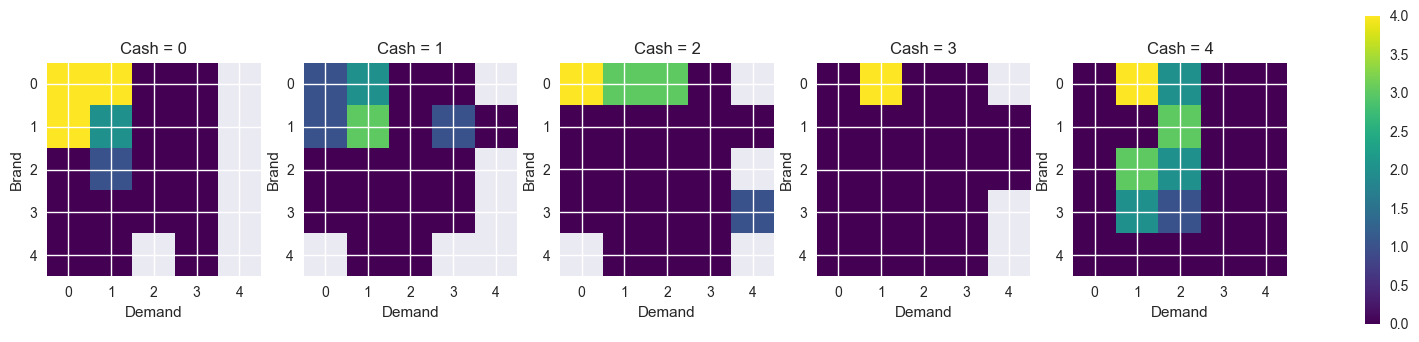

In [38]:
policy = extract_policy(Q)

policy_map = np.full((5,5,5), np.nan)

for (d,b,c), a in policy.items():
    policy_map[d,b,c] = a

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,5, figsize=(20,4))

for c in range(5):
    ax = axes[c]
    ax.imshow(policy_map[:,:,c], cmap='viridis', vmin=0, vmax=4)
    ax.set_title(f"Cash = {c}")
    ax.set_xlabel("Demand")
    ax.set_ylabel("Brand")
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))

plt.colorbar(ax.images[0], ax=axes.ravel().tolist())
plt.show()


In [42]:
def expected_q_value(q_values, epsilon):
    n_actions = len(q_values)
    
    # 1) Find greedy action
    best_action = np.argmax(q_values)

    # 2) Create probability distribution under ε-greedy
    probs = np.ones(n_actions) * (epsilon / n_actions)
    

    probs[best_action] += (1 - epsilon)

    # 3) Compute expectation
    expected_Q = np.sum(probs * q_values)
    return expected_Q

def expected_sarsa_update(Q, state, action, reward, next_state, alpha, gamma, epsilon):
    q_value_next = Q[next_state]

    n_actions = len(q_value_next)
    best_action = np.argmax(q_value_next)

    probs = np.ones(n_actions) * (epsilon / n_actions)
    probs[best_action] += (1 - epsilon)

    expected_Q = np.sum(probs * q_value_next)

    Q[state][action] += alpha * (reward + gamma * expected_Q - Q[state][action])

    return Q


In [43]:
def epsilon_greedy(Q, state, epsilon):

    if state not in Q:
        Q[state] = np.zeros(5)

    rand = np.random.random()

    if rand < epsilon:
        return np.random.choice(5)
    else:
        return np.argmax(Q[state])


def expected_sarsa(env, alpha, gamma, epsilon, num_steps):

    Q = {}
    state = env.reset()
    if state not in Q:
        Q[state] = np.zeros(5)

    for t in range(num_steps):

        # 1) Select action using epsilon-greedy
        action = epsilon_greedy(Q, state, epsilon)

        # 2) Take step in the environment
        next_state, reward, done, _ = env.step(action)

        # 3) Initialize Q for next_state if unseen
        if next_state not in Q:
            Q[next_state] = np.zeros(5)

        # 4) Perform Expected SARSA update
        Q = expected_sarsa_update(Q, state, action, reward, next_state,
                                  alpha, gamma, epsilon)

        # 5) Move to the next state
        state = next_state

    return Q


In [44]:
def run_expected_sarsa_experiment(env, alpha, gamma, epsilon,
                                  num_episodes, steps_per_episode):

    Q = {}
    episode_returns = []

    for ep in range(num_episodes):
        state = env.reset()
        if state not in Q:
            Q[state] = np.zeros(5)

        G = 0.0  # return (sum of rewards this episode)

        for t in range(steps_per_episode):

            # 1) Choose action with epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # 2) Step in environment
            next_state, reward, done, _ = env.step(action)
            G += reward

            # 3) Ensure Q[next_state] exists
            if next_state not in Q:
                Q[next_state] = np.zeros(5)

            # 4) Expected SARSA update
            Q = expected_sarsa_update(Q, state, action, reward,
                                      next_state, alpha, gamma, epsilon)

            # 5) Move to next state
            state = next_state

        # 6) Log episode return
        episode_returns.append(G)

    return Q, episode_returns


In [48]:
Q = run_expected_sarsa_experiment(env, alpha=0.1, gamma=0.95, epsilon=0.1, num_episodes=500, steps_per_episode=50)

In [50]:
def run_sarsa_experiment(env, alpha, gamma, epsilon,
                         num_episodes, steps_per_episode):

    Q = {}
    episode_returns = []

    for ep in range(num_episodes):

        state = env.reset()
        if state not in Q:
            Q[state] = np.zeros(5)

        # SARSA picks the FIRST action BEFORE stepping
        action = epsilon_greedy(Q, state, epsilon)

        G = 0.0

        for t in range(steps_per_episode):

            next_state, reward, done, _ = env.step(action)
            G += reward

            if next_state not in Q:
                Q[next_state] = np.zeros(5)

            # 1) SARSA must choose next action using epsilon-greedy
            next_action = epsilon_greedy(Q, next_state, epsilon)

            # 2) Compute SARSA update
            td_target = reward + gamma * Q[next_state][next_action]
            td_error  = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            # 3) Transition
            state = next_state
            action = next_action

        episode_returns.append(G)

    return Q, episode_returns


In [52]:
import numpy as np

def policy_grid_from_Q(Q, fixed_cash=2, max_level=4, n_actions=5):
    policy_grid = np.zeros((max_level + 1, max_level + 1), dtype=int)

    for d in range(max_level + 1):
        for b in range(max_level + 1):
            state = (d, b, fixed_cash)

            if state in Q:
                q_vals = Q[state]
            else:
                q_vals = np.zeros(n_actions)

            # QUESTION: choose best action for this state
            best_action = np.argmax(q_vals)

            policy_grid[d, b] = best_action

    return policy_grid


In [54]:
alpha = 0.1
gamma = 0.9
epsilon = 0.1

num_episodes = 2000
steps_per_episode = 50

env = CompanyEnv(gamma=gamma, seed=42)

Q_exp, returns_exp = run_expected_sarsa_experiment(
    env, alpha, gamma, epsilon,
    num_episodes=num_episodes,
    steps_per_episode=steps_per_episode
)

# Recreate env to avoid reusing internal RNG state if you want cleaner comparison
env2 = CompanyEnv(gamma=gamma, seed=43)

Q_sarsa, returns_sarsa = run_sarsa_experiment(
    env2, alpha, gamma, epsilon,
    num_episodes=num_episodes,
    steps_per_episode=steps_per_episode
)


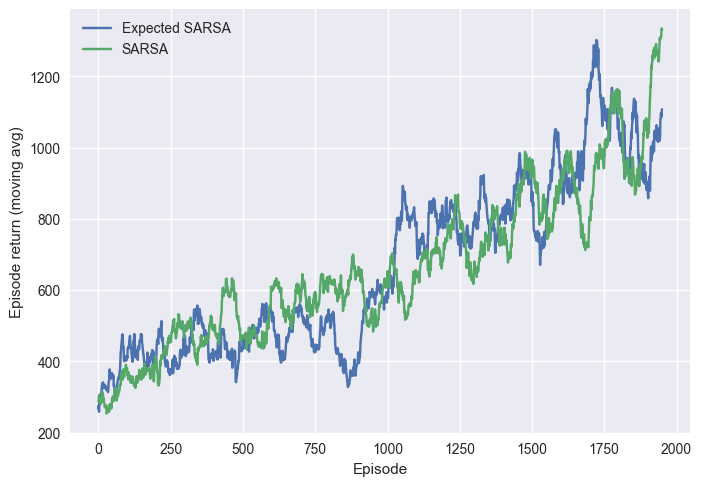

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(x, window=50):
    x = np.array(x)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode='valid')

ma_exp   = moving_average(returns_exp, window=50)
ma_sarsa = moving_average(returns_sarsa, window=50)

plt.figure()
plt.plot(ma_exp,   label="Expected SARSA")
plt.plot(ma_sarsa, label="SARSA")
plt.xlabel("Episode")
plt.ylabel("Episode return (moving avg)")
plt.legend()
plt.grid(True)
plt.show()


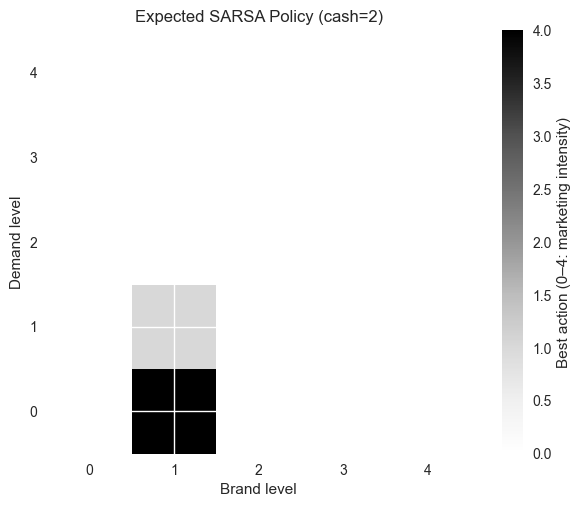

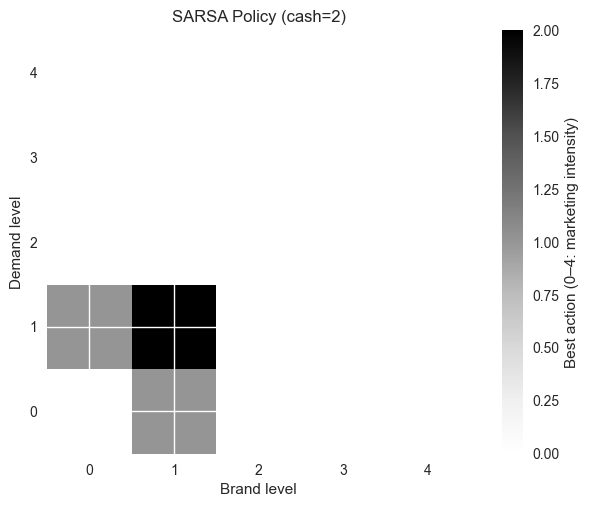

In [58]:
def policy_grid_from_Q(Q, fixed_cash=2, max_level=4, n_actions=5):
    policy_grid = np.zeros((max_level + 1, max_level + 1), dtype=int)

    for d in range(max_level + 1):
        for b in range(max_level + 1):
            state = (d, b, fixed_cash)

            if state in Q:
                q_vals = Q[state]
            else:
                q_vals = np.zeros(n_actions)

            best_action = np.argmax(q_vals)
            policy_grid[d, b] = best_action

    return policy_grid

policy_exp   = policy_grid_from_Q(Q_exp,   fixed_cash=2)
policy_sarsa = policy_grid_from_Q(Q_sarsa, fixed_cash=2)

def plot_policy_heatmap(policy_grid, title):
    plt.figure()
    plt.imshow(policy_grid, origin='lower', interpolation='nearest')
    plt.colorbar(label="Best action (0–4: marketing intensity)")
    plt.xlabel("Brand level")
    plt.ylabel("Demand level")
    plt.title(title)
    plt.xticks(range(5))
    plt.yticks(range(5))
    plt.show()

plot_policy_heatmap(policy_exp,   "Expected SARSA Policy (cash=2)")
plot_policy_heatmap(policy_sarsa, "SARSA Policy (cash=2)")

